In [4]:
import torch
import numpy as np
from torch import nn
from torch import optim
import os
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets ,transforms, models
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from torch.autograd import Variable


In [2]:
data_dir='gender_data/Training'

def load_split_train_test(data_dir,transform,valid_size=0.2):
    train_data=datasets.ImageFolder(data_dir,transform=transform)
    test_data=datasets.ImageFolder(data_dir,transform=transform)
    
    num_train=len(train_data)
    indices=list(range(num_train))
    split=int(np.floor(valid_size*num_train))
    np.random.shuffle(indices)

    train_idx,test_idx=indices[split:],indices[:split]
    train_sampler=SubsetRandomSampler(train_idx)
    test_sampler=SubsetRandomSampler(test_idx)
    
    trainloader=torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size=64)
    testloader=torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size=64)
    
    return trainloader,testloader

    

In [4]:
transform=transforms.Compose([transforms.Resize((80,80)),transforms.ToTensor(),])

In [4]:
trainloader,testloader=load_split_train_test(data_dir,transform,.2)

print(trainloader.dataset.classes)

for batch_images, targets in trainloader:
    print(batch_images.shape)

['female', 'male']
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
torch.Size([64, 3, 80, 80])
t

In [5]:
# check if gpu is present or not 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model= models.resnet50(pretrained=True)
print(model)


cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

)


In [6]:
for param in model.parameters():
    param.requires_grad=False
    

In [7]:
model.fc=nn.Sequential(nn.Linear(2048,512),
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(512,10),
                       nn.LogSoftmax(dim=1))
model.to(device)
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.fc.parameters(),lr=0.003)



In [8]:
epochs=20
steps=0

running_loss=0

print_every=10

train_losses,test_losses=[],[]

for epoch in range(epochs):
    for inputs,labels in trainloader:
        steps+=1
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        logps=model.forward(inputs)
        loss=criterion(logps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
        if steps%print_every==0:
            test_loss=0
            accuracy=0
            for inputs,labels in testloader:
                inputs,labels=inputs.to(device),labels.to(device)
                logps=model.forward(inputs)
                batch_loss=criterion(logps,labels)
                test_loss += batch_loss.item()
                ps=torch.exp(logps)
                
                top_p,top_class=ps.topk(1,dim=1)
                equals= top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss=0
            model.train()
            
            
torch.save(model,'classifymodel.pth')

Epoch 1/20.. Train loss: 2.861.. Test loss: 1.440.. Test accuracy: 0.472
Epoch 1/20.. Train loss: 0.837.. Test loss: 0.711.. Test accuracy: 0.652
Epoch 1/20.. Train loss: 0.688.. Test loss: 0.690.. Test accuracy: 0.660
Epoch 1/20.. Train loss: 0.570.. Test loss: 0.413.. Test accuracy: 0.822
Epoch 1/20.. Train loss: 0.526.. Test loss: 0.413.. Test accuracy: 0.809
Epoch 2/20.. Train loss: 0.351.. Test loss: 0.379.. Test accuracy: 0.837
Epoch 2/20.. Train loss: 0.364.. Test loss: 0.340.. Test accuracy: 0.853
Epoch 2/20.. Train loss: 0.369.. Test loss: 0.419.. Test accuracy: 0.816
Epoch 2/20.. Train loss: 0.361.. Test loss: 0.343.. Test accuracy: 0.850
Epoch 2/20.. Train loss: 0.323.. Test loss: 0.317.. Test accuracy: 0.863
Epoch 2/20.. Train loss: 0.360.. Test loss: 0.311.. Test accuracy: 0.868
Epoch 3/20.. Train loss: 0.340.. Test loss: 0.308.. Test accuracy: 0.869
Epoch 3/20.. Train loss: 0.321.. Test loss: 0.312.. Test accuracy: 0.866
Epoch 3/20.. Train loss: 0.323.. Test loss: 0.329..

Epoch 20/20.. Train loss: 0.176.. Test loss: 0.218.. Test accuracy: 0.908
Epoch 20/20.. Train loss: 0.236.. Test loss: 0.143.. Test accuracy: 0.950
Epoch 20/20.. Train loss: 0.173.. Test loss: 0.202.. Test accuracy: 0.911


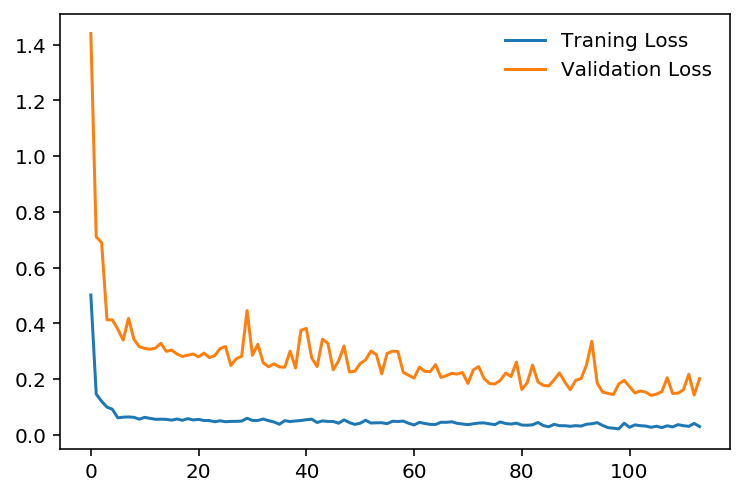

In [9]:
plt.plot(train_losses,label='Traning Loss')
plt.plot(test_losses,label='Validation Loss')

plt.legend(frameon=False)
plt.show()

In [5]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import cv2
from PIL import Image,ImageDraw
from IPython import display
import imutils

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Load Model
model=torch.load('classifymodel.pth')
model.eval()

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
mtcnn=MTCNN(keep_all=True, device=device)
transform=transforms.Compose([transforms.Resize((80,80)),transforms.ToTensor(),])

classes=['female','male']
check_transforms=transforms.Compose([transforms.Resize((80,80)),transforms.ToTensor(),
                                     transforms.ToPILImage(),])

In [8]:
def predict_image(image):
    image_tensor=transform(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    input= Variable(image_tensor).to(device)
    output=model(input)
    
    index=output.data.cpu().numpy().argmax()
    return index

In [9]:
"""
cap=cv2.VideoCapture(0)


frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
size = (frame_width, frame_height)
#result = cv2.VideoWriter('output.avi',  cv2.VideoWriter_fourcc(*'MJPG'), 20,size )


while True:
    ret,image=cap.read()
    frame=image.copy()
    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

    boxes,_=mtcnn.detect(frame)

    color=(0,255,0)
    if boxes is not None:
        for box in boxes:
            startX,endX=int(box[0])-1,int(box[2])+1
            startY,endY=int(box[1])-1,int(box[3])+1
            cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]) , color, 2)
            face = frame[startY:endY, startX:endX]
            img = Image.fromarray(face)
            img=check_transforms(img)
            index=predict_image(img)
            label=str(classes[index])
            color = (0, 255, 0)
            cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            #result.write(image)
    cv2.imshow("frame",image)
    k=cv2.waitKey(1) & 0xFF
    if k == ord("q"):
        print("Escapehit, closing...")
        break
cap.release()
#result.release()
cv2.destroyAllWindows()

"""

'\ncap=cv2.VideoCapture(0)\n\n\nframe_width = int(cap.get(3)) \nframe_height = int(cap.get(4)) \nsize = (frame_width, frame_height)\n#result = cv2.VideoWriter(\'output.avi\',  cv2.VideoWriter_fourcc(*\'MJPG\'), 20,size )\n\n\nwhile True:\n    ret,image=cap.read()\n    frame=image.copy()\n    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)\n\n    boxes,_=mtcnn.detect(frame)\n\n    color=(0,255,0)\n    if boxes is not None:\n        for box in boxes:\n            startX,endX=int(box[0])-1,int(box[2])+1\n            startY,endY=int(box[1])-1,int(box[3])+1\n            cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]) , color, 2)\n            face = frame[startY:endY, startX:endX]\n            img = Image.fromarray(face)\n            img=check_transforms(img)\n            index=predict_image(img)\n            label=str(classes[index])\n            color = (0, 255, 0)\n            cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)\n            #result.wr

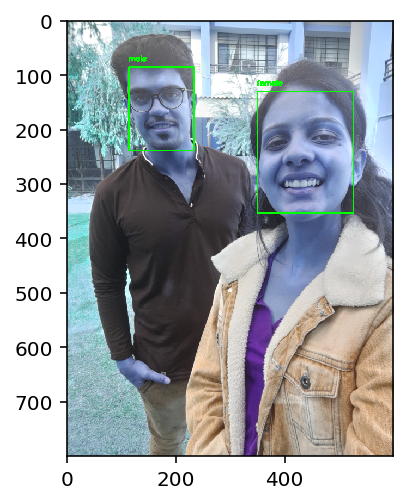

In [12]:
image=cv2.imread("Sample Images/Image1.jpg")
image=imutils.resize(frame,width=600)
frame=image.copy()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

boxes,_=mtcnn.detect(frame)

color=(0,255,0)
if boxes is not None:
    for box in boxes:
        startX,endX=int(box[0])-1,int(box[2])+1
        startY,endY=int(box[1])-1,int(box[3])+1
        cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]) , color, 2)
        face = frame[startY:endY, startX:endX]
        img = Image.fromarray(face)
        img=check_transforms(img)
        index=predict_image(img)
        label=str(classes[index])
        color = (0, 255, 0)
        cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        #result.write(image)
plt.imshow(image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()